In [ ]:
#!/usr/bin/env python
# coding: utf-8

# 20221129
# 
# sarahfong
# 
# ### intersect nullomers, empirical shuffle with phylop 100way bigWig
# 
# split by exonic/non-exonic
# 
# 
# use bigWigSummary executable from UCSC to get phylop 
# 
# 
# compare nullomers v. empirical background

# In[ ]:
—

In [1]:
import glob
from joblib import Parallel, delayed
import os
import pybedtools as pbt
import subprocess
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels as sm

# append path
sys.path.append("/wynton/home/ahituv/fongsl/tools/py_/")

# import config reader
import config_readwrite as crw
import zippery



config_tag = "config-exon.ini"

# append path
sys.path.append("/wynton/home/ahituv/fongsl/tools/py_/")

# import config reader
import config_readwrite as crw
import count_lines as cl
import plot_params as pp

config_name = os.path.join(os.getcwd(), config_tag)

config, configname = crw.read_config(config_name)


# Analysis

In [2]:
DATASET = "LINSIGHT"

DATA_PATH = config[DATASET]["PATH"]
RE_PATH = config["RESULTS"]["PATH"] 

ANNOT = config["GENCODE"]["ANNOT"] 

RE = os.path.join(RE_PATH, DATASET)

if os.path.exists(RE) is False:
    os.mkdir(RE)
    config["RESULTS"][DATASET] = RE 

## functions

In [3]:
def plot_lines(df, out_pdf,datatype, xrange):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.lineplot(df, x="pos", y= '50%', hue = "label" )
    sns.lineplot(df, x="pos", y= '25%', hue = "label")
    sns.lineplot(df, x="pos", y= '75%', hue = "label")

    ax.axvline(499, color="grey", ls = "--") # center line
    
    ax.set(xlim = (xrange[0], xrange[1]),
           ylabel = f"{DATASET} score",
            title = f"{datatype}:{xrange[0]}-{xrange[1]}")
    
    ax.legend(loc="upper right")
    
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    
def plot_line(y, df, out_pdf,datatype, xrange):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.lineplot(df, x="pos", y=y, hue="label")
    
    ax.axvline(499, color="grey", ls = "--") # center line
    
    ax.set(xlim = (xrange[0], xrange[1]),
           ylabel = f"{DATASET} score-{y}",
            title = f"{datatype}-{y}:{xrange[0]}-{xrange[1]}")
    
    ax.legend(loc="upper right")
    
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    
    
def calculateEmpiricalP(obs, exp_sum_list):
    
    import datetime
    """
    return two lists
        (1) info - vector w/  
                n_obs, 
                median_exp, 
                std, 
                fold-change  # calculated from the median of expected shuffle 
                p_val
                
        (2) fold_changes- vector expected fold changes (to calculate confidence interval)
        
    input
        observed overlap count (int)
        list of expected overlap counts (list of ints)
    
    method
        1. get median of expected overlap counts
        2. get standard deviation of expected overlap counts
        3. center expected overlap counts at median
        4. Sum the number of centered expected counts greater than observed centered count
            This is two tailed because it evaluates both sides of the distribution (w/ abs value). 
        5. calculate fold change as observed/ median expected w/ pseudo count
        6. calculate fold change of each "obs"/ expected w/ pseudo count
        7. calculate the p-value as count of equal or more extreme values than observed value
        8. return list of empirical info + fold changes
        
        
    
    """
    #1
    mu = np.median(exp_sum_list)  # median of exp.dist
    
    #2
    sigma = np.std(exp_sum_list)  # std
    
    #3
    dist_from_mu = [exp - mu for exp in exp_sum_list] # center the distribution 
    
    #4
    p_sum = sum(1 for exp_dist in dist_from_mu if abs(exp_dist) >= abs(obs - mu)) # count values >= centered obs

    #5
    fold_change = (obs + 1.0) / (mu + 1.0) # fold change obs from median expected w pseudo count
    
    #6
    fold_changes = list((obs + 1.0) / (m + 1.0) for m in exp_sum_list) # fold change obs from /each exp w pseudo count
    
    #7
    p_val = (p_sum + 1.0) / (len(exp_sum_list) + 1.0)  # probability of observing obs-like value equal or more extreme in expected distribution
    
    #8
    info = [
            obs, 
            mu, 
            sigma, 
            fold_change, 
            p_val, 
            str(datetime.datetime.now())
            ]
    
    return info, fold_changes

def exp(nullo, shuf, summary_stat_name, pos):
    """
    return PER POSITION foldchange, empirical P between observed and expected (shuffled) data
    
    input
        nullo (df) - pandas dataframe of nullomer summary stats in long form (each row is one base in dist)
        shuf (df) - pandas dataframe of N shuffled summary stats in long form (each row is one base in dist)
        summary_stat_name (str) - summary_stat measurement name (this should be a column in the dataframes)
        pos (int) - relative position of the base to estimate fold change between. 
        
    method
        1. prepare position phylop vectors for obs, exp
        2. calculate empirical P
    
    
    """
    obs = nullo.loc[nullo["pos"]== pos, summary_stat_name].iloc[0]
    exp_list =  shuf.loc[shuf["pos"]== pos, summary_stat_name].to_list()
    
    info, fold_changes = calculateEmpiricalP(obs, exp_list)
    
    print(info)
    
    return info, fold_changes

In [4]:
def formatDf(datatype, query):
    """
    glob all query files for datatype and turn these data into a single dataframe
    split dataframe based on nullomer v shuffle
    
    input 
        datatype (str) - label for dataset (e.g. exon-overlpa, no exon-overlap)
        query (str) - fragment of str to glob files on. 
        
    method
        1. glob all files
        2. make a list to collect pandas dataframes
        3. assign LABEL - NULLOMER/SHUF  for each dataset. 
        4. assign ID - str of the file name
        5. open the file as a pandas dataframe, add label, id columns, append to collection list
        6. concatenate all dataframes together
        7. split dataframes on NULLOMER/SHUF label
        
    return 
        df (pd dataframe) - all data
        nullo (pd dataframe) - data for just nullomers
        shuf (pd dataframe) - data for just matched shuffles
        
    """
    #1
    file_list = glob.glob(os.path.join(DATA_PATH, query))
    print(len(file_list))
    
    #2
    df_list = []
    
    #3
    for f in file_list:
    
        # assign static label
        if "shuf" in f:
            LABEL = f"SHUF-{datatype}"
        else:
            LABEL = datatype
        #4
        ID = f.split("/")[-1]
        
        #5
        df = pd.read_csv(f, sep='\t')
        
        df["label"], df["id"] = LABEL, ID

        df_list.append(df)    
    #6
    df = pd.concat(df_list)
    
    #7
    nullo = df.loc[df["label"] == datatype]
    shuf = df.loc[df["label"] != datatype]

    return df, nullo, shuf

In [5]:
def center_stats(nullo, shuf):
    """
    print obs v. exp at center position stats w/ median values
    """
    
    # MIDPOINT - median summary stats 
    i, f = exp(nullo, shuf, "50%", 500)

    # MIDPOINT-100 - median summary stats 
    i, f = exp(nullo, shuf, "50%", 400)

    # MIDPOINT+100 - median summary stats 
    i, f = exp(nullo, shuf, "50%", 600)

EXON-OVERLAP
478


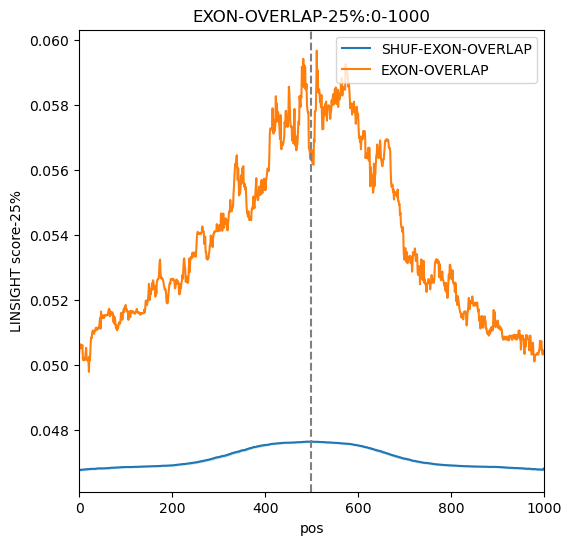

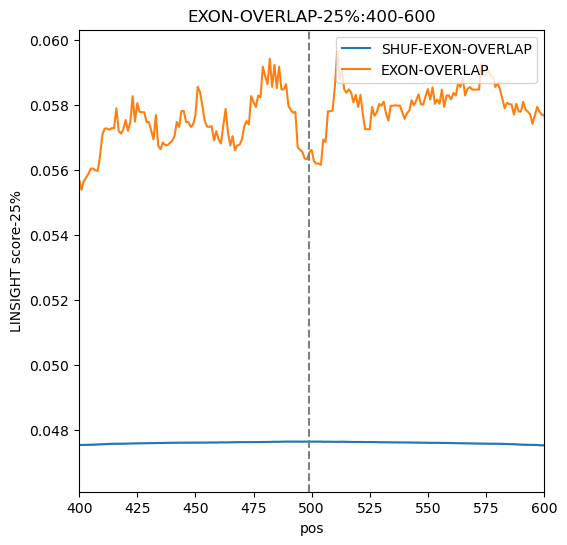

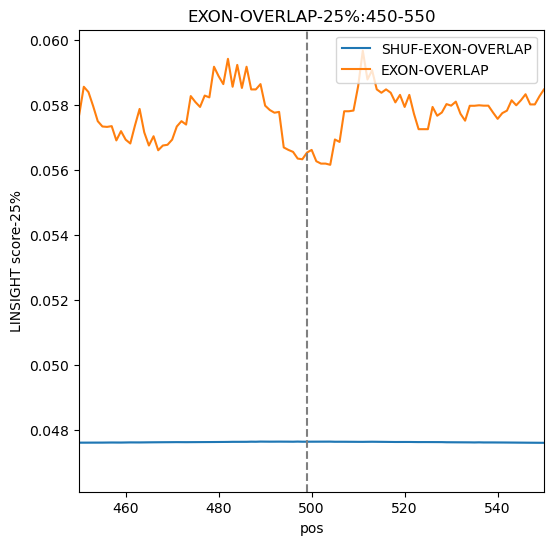

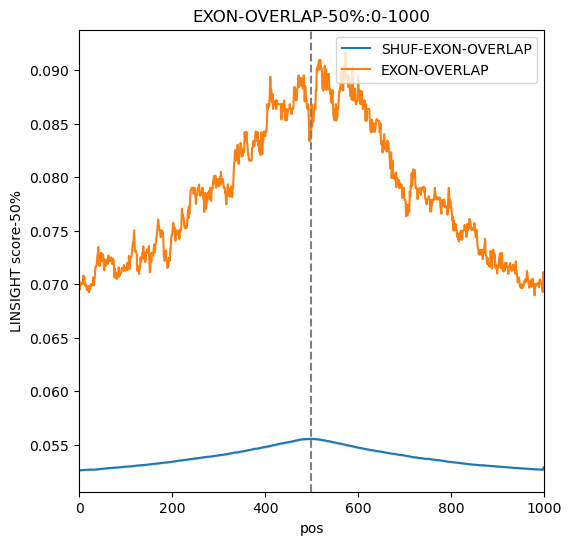

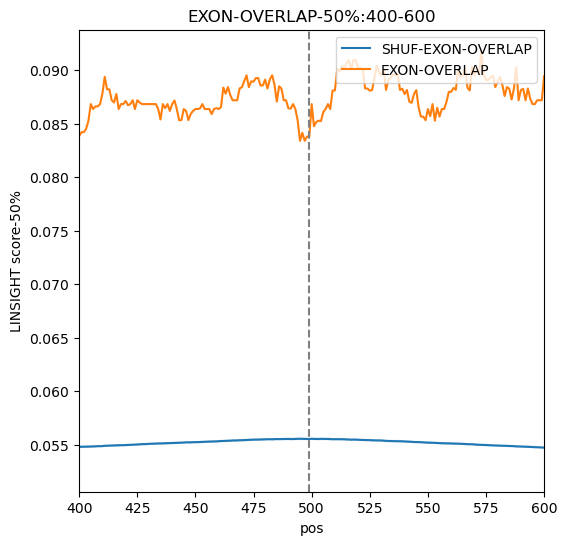

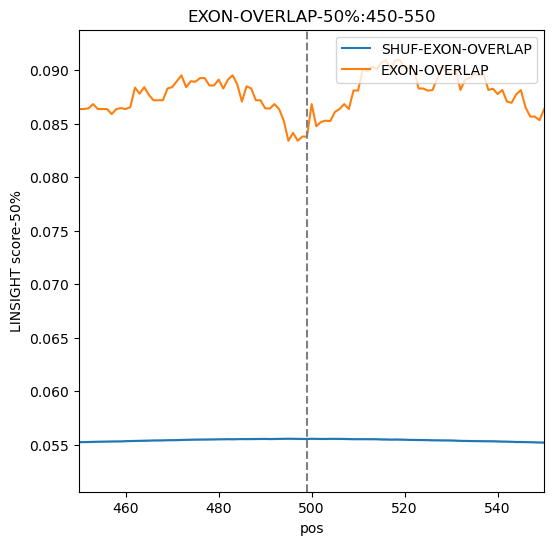

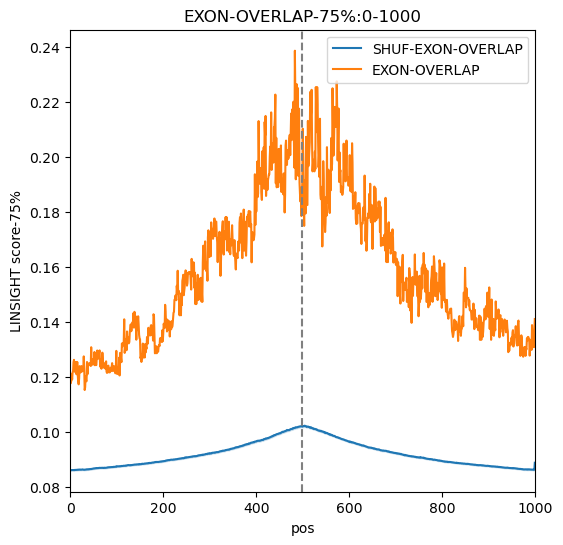

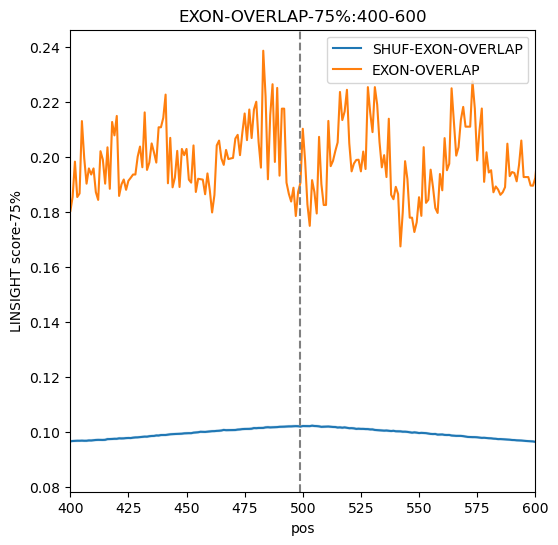

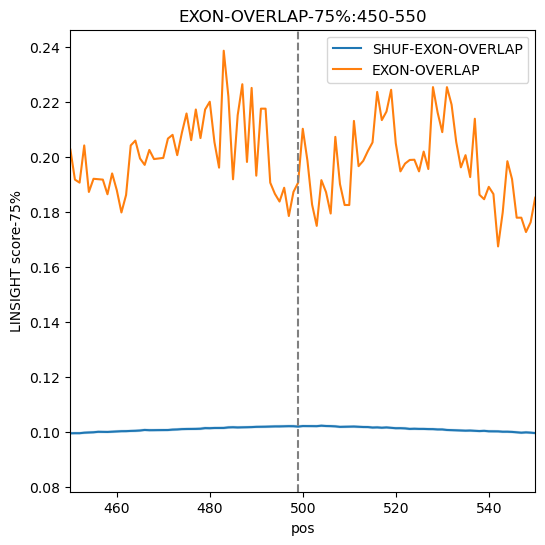

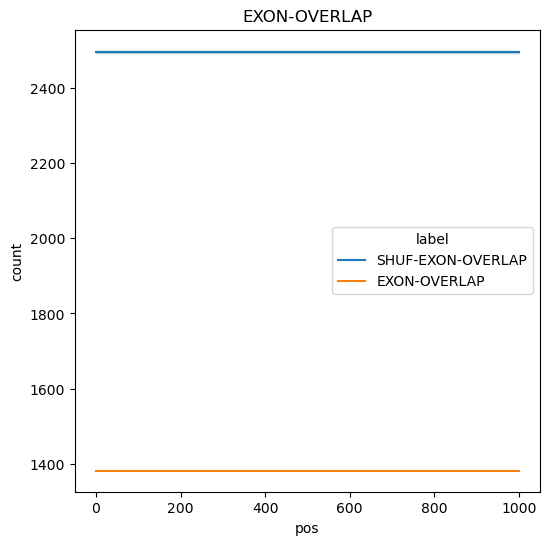

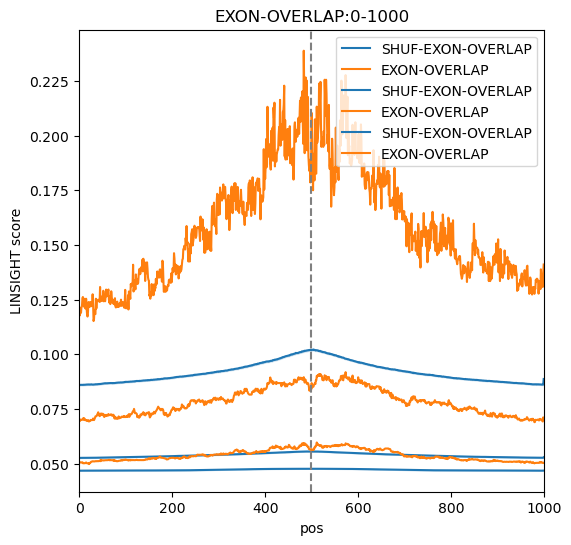

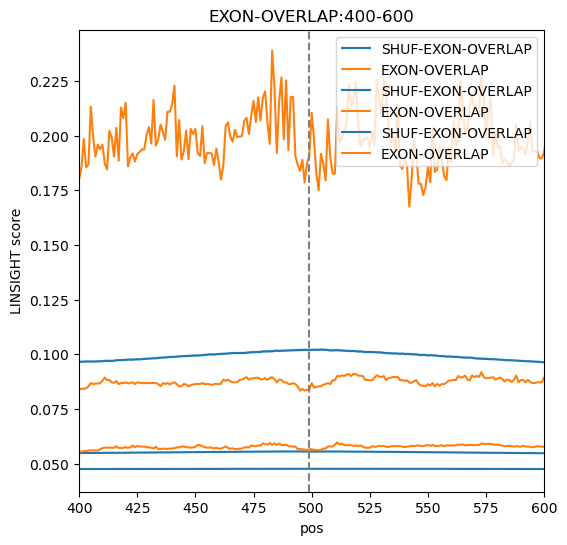

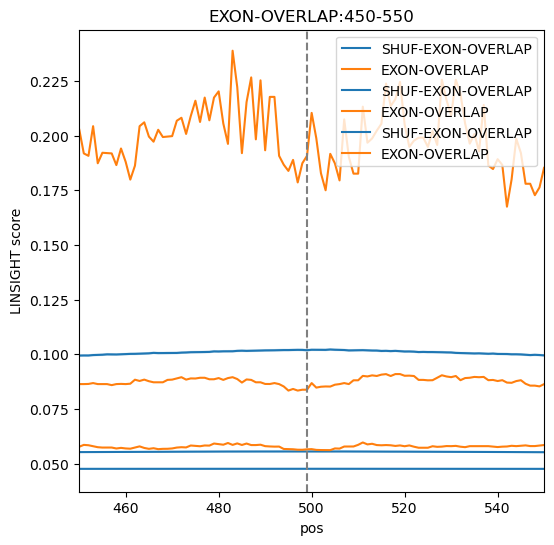

[0.0868177, 0.0554835, 0.0006083824511934698, 1.0296870581112827, 0.0020920502092050207, '2023-01-04 16:33:01.909506']
[0.0838234, 0.0547015, 0.0005439375429109411, 1.0276115090383393, 0.0020920502092050207, '2023-01-04 16:33:01.911597']
[0.0894568, 0.0546611, 0.0005368087020690031, 1.0329923043525546, 0.0020920502092050207, '2023-01-04 16:33:01.913552']
[0.0698946, 0.0526402, 0.00039694137076622306, 1.0163915457532404, 0.0020920502092050207, '2023-01-04 16:33:01.916155']
[0.0699066, 0.0526402, 0.0003909476845780564, 1.016402945659875, 0.0020920502092050207, '2023-01-04 16:33:01.917752']
[0.069517, 0.0526402, 0.00039840658744416744, 1.016032828691133, 0.0020920502092050207, '2023-01-04 16:33:01.919330']
[0.0701503, 0.0526402, 0.000397608585935495, 1.0166344587637828, 0.0020920502092050207, '2023-01-04 16:33:01.920861']
[0.0700798, 0.0526402, 0.00040093091684186764, 1.0165674843123036, 0.0020920502092050207, '2023-01-04 16:33:01.922438']
[0.0700654, 0.0526402, 0.00040430062255578564, 1.

[0.0709597, 0.0531115, 0.0004252143092237864, 1.0169480629543974, 0.0020920502092050207, '2023-01-04 16:33:02.112297']
[0.071568, 0.0531233, 0.00042867270141832246, 1.0175142834651936, 0.0020920502092050207, '2023-01-04 16:33:02.114297']
[0.071504, 0.0531215, 0.0004288545052513495, 1.0174552508898547, 0.0020920502092050207, '2023-01-04 16:33:02.115723']
[0.0725067, 0.0531461, 0.0004344222114871367, 1.018383584195963, 0.0020920502092050207, '2023-01-04 16:33:02.117168']
[0.0721084, 0.05315635, 0.00043014316807318804, 1.017995476170276, 0.0020920502092050207, '2023-01-04 16:33:02.118570']
[0.0721826, 0.0531617, 0.00042873992037023454, 1.0180607593306898, 0.0020920502092050207, '2023-01-04 16:33:02.120011']
[0.0725796, 0.0531617, 0.00043430466938003035, 1.0184377194879002, 0.0020920502092050207, '2023-01-04 16:33:02.121443']
[0.0729559, 0.0531576, 0.00043886959677419233, 1.0187989907683332, 0.0020920502092050207, '2023-01-04 16:33:02.122860']
[0.0729304, 0.0531762, 0.0004359629994128885, 

[0.07795, 0.0538817, 0.0004646571066434712, 1.0228377625306522, 0.0020920502092050207, '2023-01-04 16:33:02.316533']
[0.0785264, 0.0539286499999999, 0.0004639903020207124, 1.0233391036480506, 0.0020920502092050207, '2023-01-04 16:33:02.318091']
[0.0774718, 0.0539334, 0.0004693617911124142, 1.0223338590465014, 0.0020920502092050207, '2023-01-04 16:33:02.319532']
[0.0770466, 0.0539166, 0.0004737475782030121, 1.0219467081171318, 0.0020920502092050207, '2023-01-04 16:33:02.320980']
[0.0774851, 0.0539334499999999, 0.00047841841282170644, 1.0223464299382472, 0.0020920502092050207, '2023-01-04 16:33:02.322406']
[0.0777332, 0.053945, 0.00048074599267610395, 1.0225706274995374, 0.0020920502092050207, '2023-01-04 16:33:02.323843']
[0.0784769, 0.0539554, 0.00048204730456790376, 1.0232661647731964, 0.0020920502092050207, '2023-01-04 16:33:02.325257']
[0.078501, 0.0539656, 0.0004757900294621754, 1.0232791278956352, 0.0020920502092050207, '2023-01-04 16:33:02.326667']
[0.0784806, 0.0539707, 0.000479

[0.0877793, 0.0548118, 0.0005522894208740902, 1.0312543905936586, 0.0020920502092050207, '2023-01-04 16:33:02.519945']
[0.0893682, 0.054836, 0.0005498015198681365, 1.0327370321073606, 0.0020920502092050207, '2023-01-04 16:33:02.521560']
[0.088197, 0.0548368, 0.0005511354155789216, 1.0316259349313563, 0.0020920502092050207, '2023-01-04 16:33:02.522998']
[0.088197, 0.0548729, 0.0005527596414414121, 1.031590630492072, 0.0020920502092050207, '2023-01-04 16:33:02.524420']
[0.0871739, 0.0548875, 0.0005536932910742846, 1.0306064864736761, 0.0020920502092050207, '2023-01-04 16:33:02.525890']
[0.0869685, 0.0548798999999999, 0.0005555387841081269, 1.030419197483998, 0.0020920502092050207, '2023-01-04 16:33:02.527367']
[0.0877622, 0.0548957, 0.0005620123971720415, 1.0311561607465078, 0.0020920502092050207, '2023-01-04 16:33:02.528932']
[0.0863545, 0.05489075, 0.0005598974133645385, 1.0298265483890157, 0.0020920502092050207, '2023-01-04 16:33:02.530361']
[0.0868177, 0.0549062, 0.00056566184819722,

[0.0852691, 0.0550969, 0.0005822731430512371, 1.0285966151544945, 0.0020920502092050207, '2023-01-04 16:33:02.722747']
[0.0864689, 0.0550792, 0.0005820231504251812, 1.0297510366994251, 0.0020920502092050207, '2023-01-04 16:33:02.724447']
[0.0856503, 0.0550833, 0.0005768460190293405, 1.0289711722287709, 0.0020920502092050207, '2023-01-04 16:33:02.725905']
[0.0863545, 0.0550436, 0.0005823850994139901, 1.0296773517227156, 0.0020920502092050207, '2023-01-04 16:33:02.727339']
[0.0863545, 0.0550451, 0.0005830125002185352, 1.0296758877890624, 0.0020920502092050207, '2023-01-04 16:33:02.728792']
[0.0870264, 0.0550266, 0.000572339817821622, 1.0303307992424078, 0.0020920502092050207, '2023-01-04 16:33:02.730224']
[0.0879664, 0.05499645, 0.0005682997566193699, 1.031251242598968, 0.0020920502092050207, '2023-01-04 16:33:02.731693']
[0.0879576, 0.05503395, 0.0005835838710186912, 1.0312062469648489, 0.0020920502092050207, '2023-01-04 16:33:02.733151']
[0.0883244, 0.0550607, 0.0005722800681229356, 1.

[0.0790037, 0.0540496, 0.00046742107745647145, 1.023674502604052, 0.0020920502092050207, '2023-01-04 16:33:02.925829']
[0.0790037, 0.0540496, 0.00046908732123116496, 1.023674502604052, 0.0020920502092050207, '2023-01-04 16:33:02.927613']
[0.0793104, 0.0540496, 0.00046275503488659293, 1.0239654756284715, 0.0020920502092050207, '2023-01-04 16:33:02.929092']
[0.0790037, 0.0540496, 0.00046944898581806685, 1.023674502604052, 0.0020920502092050207, '2023-01-04 16:33:02.930557']
[0.0780493, 0.0540496, 0.00046449180177243944, 1.0227690423676457, 0.0020920502092050207, '2023-01-04 16:33:02.931997']
[0.0786687, 0.0540496, 0.00046618340562843693, 1.0233566807482304, 0.0020920502092050207, '2023-01-04 16:33:02.933448']
[0.0781767, 0.0540496, 0.0004701515356633222, 1.0228899095450537, 0.0020920502092050207, '2023-01-04 16:33:02.934883']
[0.0790037, 0.0540496, 0.0004703698649743086, 1.023674502604052, 0.0020920502092050207, '2023-01-04 16:33:02.936331']
[0.0781195, 0.0540496, 0.0004692591519468444, 

[0.0755287, 0.0532412, 0.00042134799904342864, 1.0211608698938097, 0.0020920502092050207, '2023-01-04 16:33:03.128716']
[0.07518, 0.0532412, 0.0004172247813695222, 1.020829796631579, 0.0020920502092050207, '2023-01-04 16:33:03.130780']
[0.075062, 0.0532412, 0.000422471229287383, 1.0207177615155958, 0.0020920502092050207, '2023-01-04 16:33:03.132210']
[0.0750201, 0.0532412, 0.00042118613506621834, 1.0206779795549206, 0.0020920502092050207, '2023-01-04 16:33:03.133610']
[0.0743981, 0.0532412, 0.0004187262588394328, 1.0200874215706717, 0.0020920502092050207, '2023-01-04 16:33:03.135009']
[0.074762, 0.0532412, 0.00041531748316336544, 1.0204329264749612, 0.0020920502092050207, '2023-01-04 16:33:03.136419']
[0.075632, 0.0532412, 0.00042191417333131324, 1.0212589480928014, 0.0020920502092050207, '2023-01-04 16:33:03.137874']
[0.0750201, 0.0532412, 0.00041171539886633915, 1.0206779795549206, 0.0020920502092050207, '2023-01-04 16:33:03.139259']
[0.0755287, 0.0532412, 0.0004157786573982144, 1.02

[0.0697378, 0.0526731, 0.00040854341632775974, 1.0162108255639855, 0.0020920502092050207, '2023-01-04 16:33:03.331640']
[0.0704815, 0.0526731, 0.0004082418046984162, 1.0169173126966007, 0.0020920502092050207, '2023-01-04 16:33:03.333321']
[0.0701946, 0.0526566, 0.0003991058639982408, 1.0166607039750666, 0.0020920502092050207, '2023-01-04 16:33:03.334720']
[0.0704815, 0.0526547, 0.0003980190948503194, 1.0169350880207917, 0.0020920502092050207, '2023-01-04 16:33:03.336104']
[0.0699804, 0.0526692, 0.0004052810375885124, 1.0164450522538324, 0.0020920502092050207, '2023-01-04 16:33:03.337481']
[0.0698734, 0.0526692, 0.0003884486619667399, 1.0163434058866738, 0.0020920502092050207, '2023-01-04 16:33:03.338877']
[0.0689672, 0.0526607, 0.0003969849142651102, 1.0154907464484995, 0.0020920502092050207, '2023-01-04 16:33:03.340251']
[0.0689672, 0.0526431, 0.00039753826189802184, 1.0155077252679467, 0.0020920502092050207, '2023-01-04 16:33:03.341625']
[0.0700149, 0.0526508, 0.00039842648047008577,

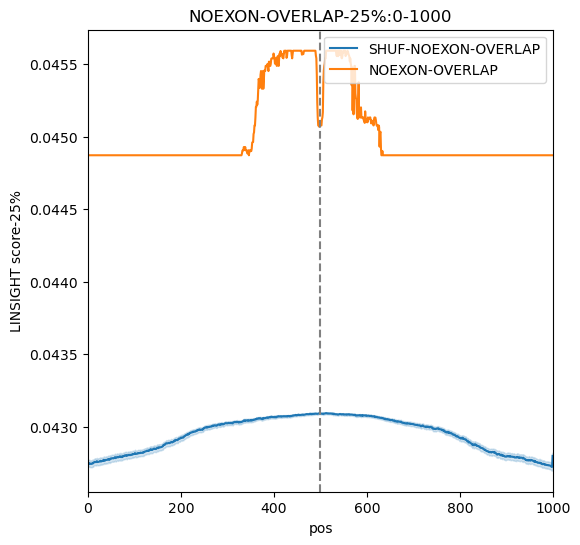

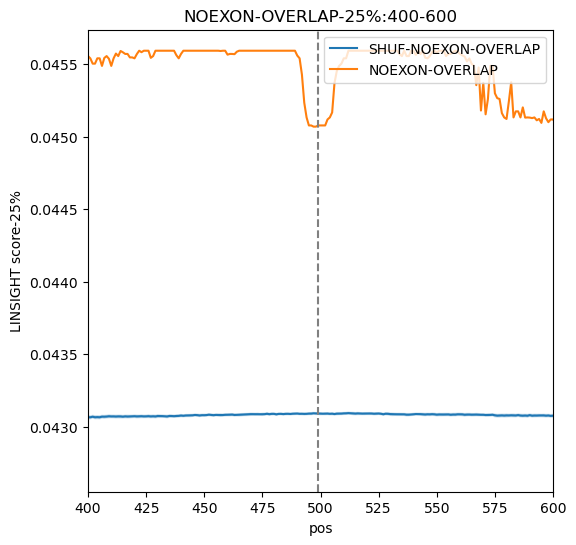

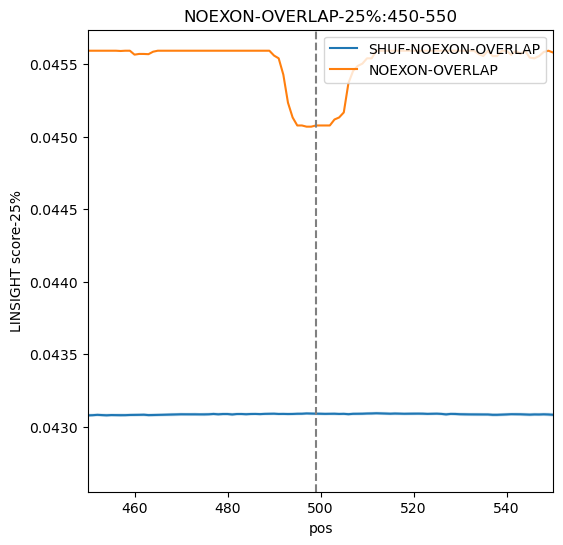

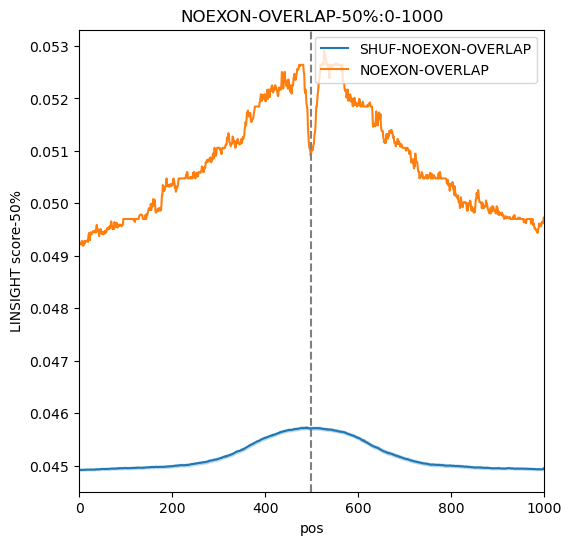

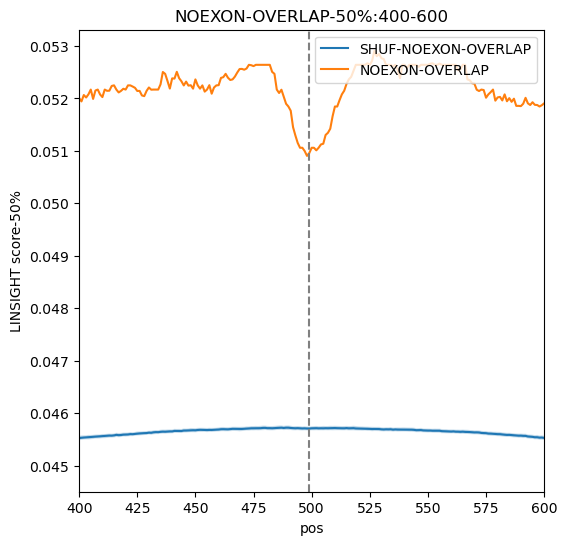

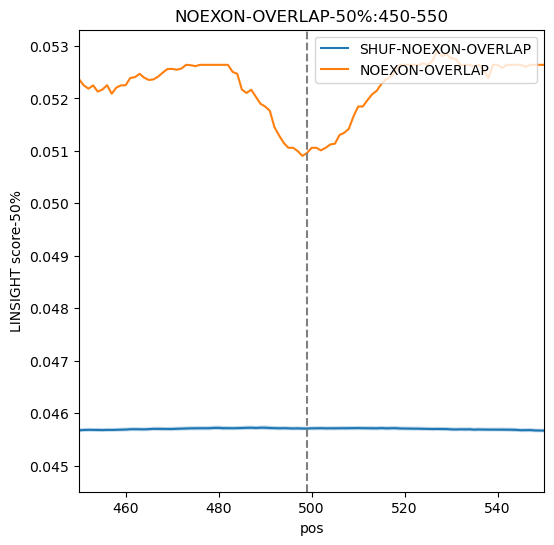

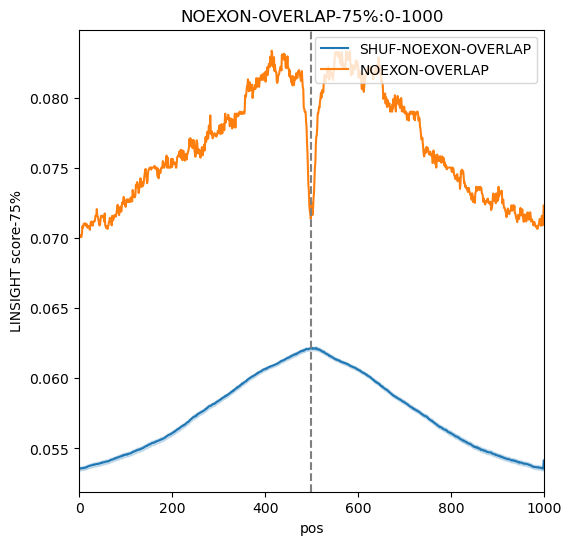

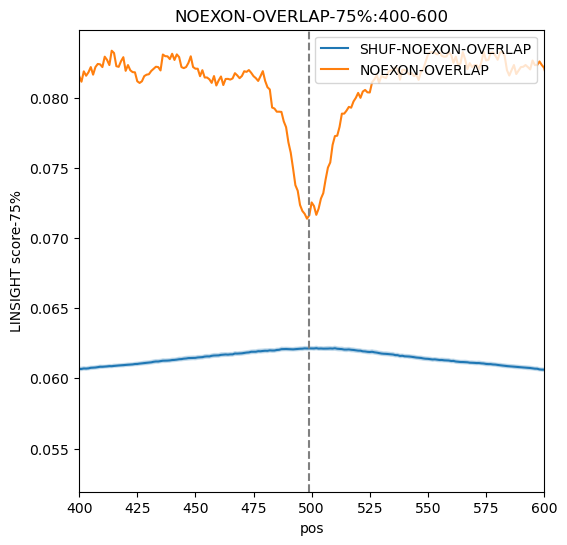

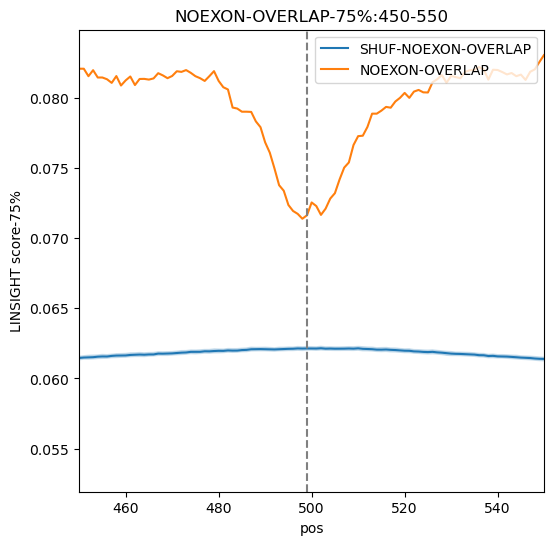

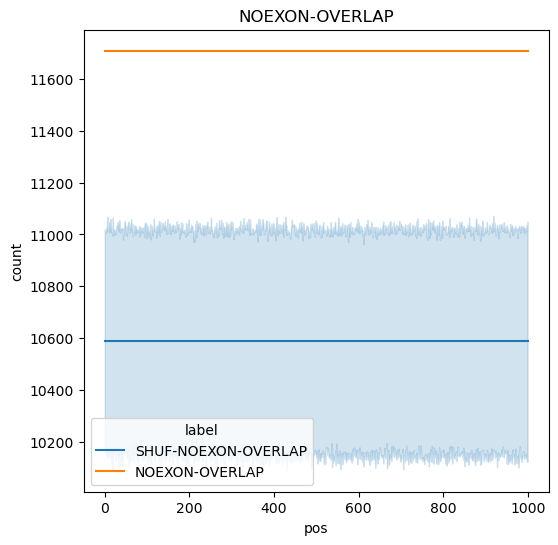

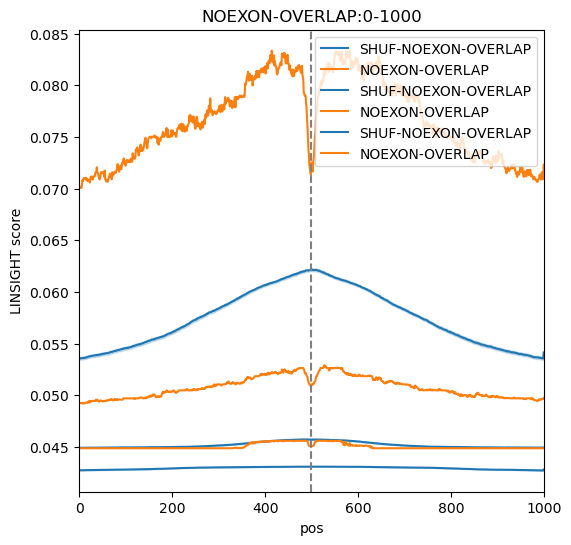

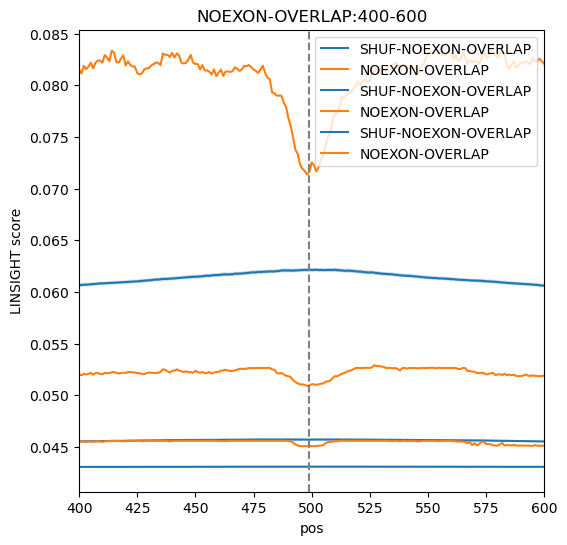

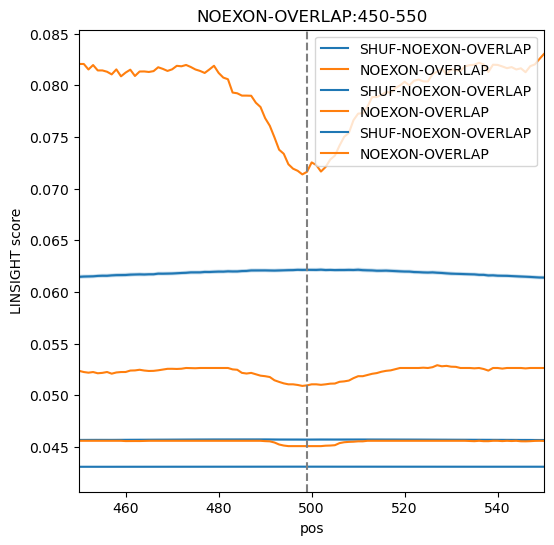

[0.0510595, 0.0455939, 0.00029189578007967834, 1.0052272684452348, 0.002188183807439825, '2023-01-04 16:42:45.019604']
[0.0520072, 0.04555195, 0.00031831448954506897, 1.0061740117265336, 0.002188183807439825, '2023-01-04 16:42:45.021582']
[0.0519068, 0.045557, 0.00030898259088478654, 1.0060731265727263, 0.002188183807439825, '2023-01-04 16:42:45.023347']
[0.0491956, 0.0448725, 0.00017551108458313254, 1.0041374426066338, 0.002188183807439825, '2023-01-04 16:42:45.025641']
[0.0492165, 0.0448725, 0.00017617694336946282, 1.004157445047123, 0.002188183807439825, '2023-01-04 16:42:45.027019']
[0.04923465, 0.0448725, 0.00017027456356400472, 1.0041748155875476, 0.002188183807439825, '2023-01-04 16:42:45.028372']
[0.0492488, 0.0448725, 0.0001680434413226312, 1.004188357909697, 0.002188183807439825, '2023-01-04 16:42:45.029741']
[0.0492488, 0.0448725, 0.00017378185082244488, 1.004188357909697, 0.002188183807439825, '2023-01-04 16:42:45.031096']
[0.04921985, 0.0448725, 0.00017564640850959475, 1.0

[0.0497834, 0.0448725, 0.0002313484035845794, 1.004699999282209, 0.002188183807439825, '2023-01-04 16:42:45.222180']
[0.04978585, 0.0448725, 0.00024086800798297822, 1.0047023440659026, 0.002188183807439825, '2023-01-04 16:42:45.223862']
[0.04985135, 0.0448725, 0.00023876548893006266, 1.0047650311401628, 0.002188183807439825, '2023-01-04 16:42:45.225229']
[0.04987445, 0.0448725, 0.00023723741090712387, 1.0047871391007035, 0.002188183807439825, '2023-01-04 16:42:45.226558']
[0.0499080499999999, 0.0448725, 0.00023655410388422968, 1.0048192961342173, 0.002188183807439825, '2023-01-04 16:42:45.227888']
[0.04987445, 0.0448725, 0.00023655255035573026, 1.0047871391007035, 0.002188183807439825, '2023-01-04 16:42:45.229211']
[0.04989235, 0.0448725, 0.00023952703419885885, 1.004804270377486, 0.002188183807439825, '2023-01-04 16:42:45.230522']
[0.04986905, 0.0448725, 0.00024404845878722142, 1.0047819710060317, 0.002188183807439825, '2023-01-04 16:42:45.231849']
[0.0499903, 0.0448725, 0.00024218621

[0.0510595, 0.0450397, 0.00029366358847781275, 1.0057603553243002, 0.002188183807439825, '2023-01-04 16:42:45.425870']
[0.0510595, 0.0450463, 0.0003014519251903757, 1.0057540034350632, 0.002188183807439825, '2023-01-04 16:42:45.427585']
[0.0510595, 0.04506175, 0.0003047004369755474, 1.0057391345535325, 0.002188183807439825, '2023-01-04 16:42:45.428934']
[0.0510595, 0.045067475, 0.0003006074656854827, 1.0057336249987112, 0.002188183807439825, '2023-01-04 16:42:45.430273']
[0.0510506, 0.0450675, 0.00030186459240585413, 1.00572508474333, 0.002188183807439825, '2023-01-04 16:42:45.431594']
[0.0510595, 0.0450725, 0.000303898898325857, 1.0057287891509918, 0.002188183807439825, '2023-01-04 16:42:45.432943']
[0.0510131999999999, 0.04507575, 0.0003032403616292844, 1.0056813585043953, 0.002188183807439825, '2023-01-04 16:42:45.434284']
[0.0510068999999999, 0.0450783, 0.00030298561522399553, 1.0056728763768228, 0.002188183807439825, '2023-01-04 16:42:45.435654']
[0.0510099, 0.0450783, 0.000304038

[0.052244, 0.0455939, 0.0002862801100516627, 1.006360117441389, 0.002188183807439825, '2023-01-04 16:42:45.628475']
[0.0522518, 0.0455939, 0.00029134805264903176, 1.0063675773165854, 0.002188183807439825, '2023-01-04 16:42:45.630055']
[0.0521861, 0.0455939, 0.0002887010161510924, 1.0063047422139704, 0.002188183807439825, '2023-01-04 16:42:45.631397']
[0.0523624, 0.0455939, 0.00028278351612591473, 1.0064733545212916, 0.002188183807439825, '2023-01-04 16:42:45.632748']
[0.0522485, 0.0455939, 0.0002879289792918288, 1.0063644212155407, 0.002188183807439825, '2023-01-04 16:42:45.634091']
[0.05218635, 0.0455939, 0.00028319708270783874, 1.0063049813125342, 0.002188183807439825, '2023-01-04 16:42:45.635421']
[0.0522486, 0.0455939, 0.00028492995899910545, 1.0063645168549662, 0.002188183807439825, '2023-01-04 16:42:45.636727']
[0.05212975, 0.0455939, 0.00028163379233849754, 1.0062508493976485, 0.002188183807439825, '2023-01-04 16:42:45.638063']
[0.0521688, 0.0455939, 0.0002813017573520576, 1.006

[0.0518458, 0.04555755, 0.0002999049619362326, 1.0060142552650497, 0.002188183807439825, '2023-01-04 16:42:45.831525']
[0.0518707, 0.045557, 0.00030490991368242715, 1.0060385995215946, 0.002188183807439825, '2023-01-04 16:42:45.833044']
[0.0519068, 0.045557, 0.00030898259088478654, 1.0060731265727263, 0.002188183807439825, '2023-01-04 16:42:45.834368']
[0.05187745, 0.045554175, 0.00030887692825625217, 1.0060477736603177, 0.002188183807439825, '2023-01-04 16:42:45.835733']
[0.0519914, 0.045544125000000005, 0.00030956333905657736, 1.0061664303264102, 0.002188183807439825, '2023-01-04 16:42:45.837066']
[0.05198675, 0.0455414, 0.0003195287105112022, 1.0061646052466213, 0.002188183807439825, '2023-01-04 16:42:45.838421']
[0.0519362, 0.0455294, 0.0003174305464596096, 1.0061278047274425, 0.002188183807439825, '2023-01-04 16:42:45.839750']
[0.0518458, 0.0455232, 0.00031693626815209306, 1.0060473072237899, 0.002188183807439825, '2023-01-04 16:42:45.841083']
[0.0518827, 0.04552125, 0.00031134438

[0.05053825, 0.0448725, 0.00029832812697627476, 1.005422431923512, 0.002188183807439825, '2023-01-04 16:42:46.034381']
[0.0504749, 0.0448725, 0.0003040280107396917, 1.005361802516575, 0.002188183807439825, '2023-01-04 16:42:46.035909']
[0.050524, 0.0448725, 0.00030661053495770684, 1.005408793895906, 0.002188183807439825, '2023-01-04 16:42:46.037252']
[0.0505226, 0.0448725, 0.0002974811852379227, 1.0054074540195095, 0.002188183807439825, '2023-01-04 16:42:46.038576']
[0.0505358, 0.0448725, 0.0002979702586932794, 1.0054200871398185, 0.002188183807439825, '2023-01-04 16:42:46.039910']
[0.05051475, 0.0448725, 0.00029594701440654477, 1.005399941141144, 0.002188183807439825, '2023-01-04 16:42:46.041261']
[0.05058335, 0.0448725, 0.00029582456533211384, 1.0054655950845675, 0.002188183807439825, '2023-01-04 16:42:46.042621']
[0.0504749, 0.0448725, 0.00029657825050297403, 1.005361802516575, 0.002188183807439825, '2023-01-04 16:42:46.043950']
[0.0504749, 0.0448725, 0.0002919155664339041, 1.005361

[0.0499093, 0.0448725, 0.000223838500657556, 1.0048204924524282, 0.002188183807439825, '2023-01-04 16:42:46.237461']
[0.04979265, 0.0448725, 0.0002233839365256225, 1.0047088520369711, 0.002188183807439825, '2023-01-04 16:42:46.239101']
[0.04985135, 0.0448725, 0.00023406127634461655, 1.0047650311401628, 0.002188183807439825, '2023-01-04 16:42:46.240451']
[0.0497803, 0.0448725, 0.00023059384937273533, 1.0046970324130455, 0.002188183807439825, '2023-01-04 16:42:46.241796']
[0.0497944, 0.0448725, 0.00021908197048506347, 1.0047105268824663, 0.002188183807439825, '2023-01-04 16:42:46.243114']
[0.04981615, 0.0448725, 0.0002106856608553274, 1.0047313428193392, 0.002188183807439825, '2023-01-04 16:42:46.244423']
[0.0497883499999999, 0.0448725, 0.0002081977351815279, 1.0047047367023247, 0.002188183807439825, '2023-01-04 16:42:46.245771']
[0.04978585, 0.0448725, 0.00021129816150709053, 1.0047023440659026, 0.002188183807439825, '2023-01-04 16:42:46.247168']
[0.0497884, 0.0448725, 0.000206684096494

In [6]:
SETS = [('EXON-OVERLAP', "*-exon_overlap*SUMMARY_STATS.txt"), 
       ("NOEXON-OVERLAP", "*-exon_no-overlap*SUMMARY_STATS.txt")]

lines = []  # for collecting stats
for DATATYPE, QUERY in SETS:
    print(DATATYPE)
    df, nullo, shuf = formatDf(DATATYPE, QUERY)

    ## plot each percentile + xranges 

    ys = ["25%", "50%", "75%"]
    ranges = [("1kb", [0,1000]), ("0.2kb", [400, 600]),  ("0.1kb", [450,550])]
    
    for y in ys:
        for name, xrange in ranges:
            out = os.path.join(RE, f"{DATASET}-{name}_{ANNOT}_{DATATYPE}-{y}.pdf")
            plot_line(y, df, out, DATATYPE, xrange)

    ## plot counts of phylop values

    fig, ax = plt.subplots(figsize=(6,6))
    sns.lineplot(df, x="pos", y= 'count', hue = "label")
    ax.set(title = DATATYPE)
    out = os.path.join(RE, f"{DATATYPE}-count.pdf")
    plt.savefig(out)

    ## plot everything together

    for name, xrange in ranges:
        out = os.path.join(RE, f"{DATASET}-{name}_{ANNOT}_{DATATYPE}.pdf")

        plot_lines(df, out, DATATYPE, xrange)
        
    ### empirical P for medians
    # MIDPOINT - median summary stats 

    center_stats(nullo, shuf)
    for pos in np.arange(0,1000):
        """
        collect obs v exp stats
        """
        i, f = exp(nullo, shuf, "50%", pos)

        i.extend([pos,f"{ANNOT}-{DATATYPE}", "50%\n"])
        i = [str(item) for item in i]
        line = "\t".join(i)
        lines.append(line)


# write all the stats to a file

In [7]:
 out_stat=os.path.join(RE, f"{DATASET}_{ANNOT}_empirical-stats.txt")

with open(out_stat, "w") as writer:
    for line in lines:
        writer.write(line)
    writer.close()